INFO:tensorflow:Restoring parameters from ./saved_models_lb/ho_cnn_model.ckpt-40590
AUC HO: 0.8980999999999999
AUC MCMC: 0.9219
AUC CNN: 0.9258


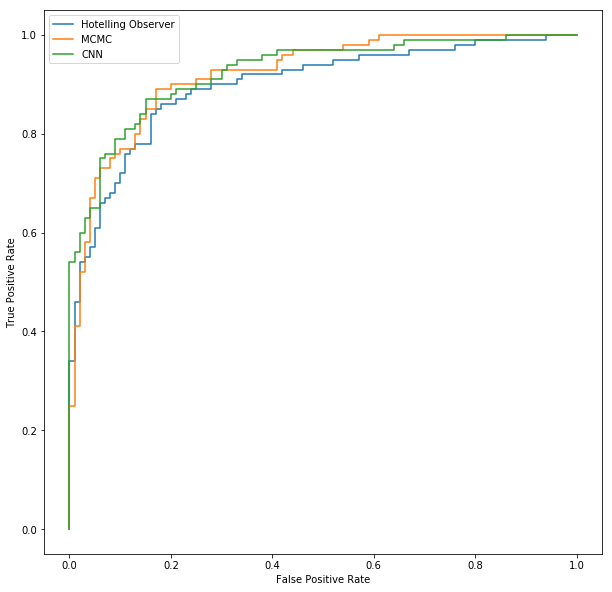

In [1]:
%matplotlib inline

import pickle
from sklearn.metrics import roc_auc_score as ras
from sklearn.metrics import roc_curve as rc
import scipy.ndimage as snd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from train_cnn import create_tf_graph
from mcmc_lumpy import *
from lumpybg import *

# load mcmc results
with open('ratios.pkl','rb') as f:
    lr, phi_set = pickle.load(f)

# Get the images for each of the phi sets
g = []
backgrounds = np.zeros((64,64,200))
for i,phi in enumerate(phi_set):
    g.append(phi.grab_g().ravel())
    theta = phi.grab_chain(real=False)[0]
    b, _, _ = create_lumpy_background(pos=theta)
    backgrounds[:,:,i] = b

# import training data and get the average difference between the 2 classes
train_set, _, train_labels, _, tmax, tmin = data_import('dataset.mat',48000)
sp = np.mean(train_set[train_labels == 1,:,:,:],axis=0).ravel()
sa = np.mean(train_set[train_labels == 0,:,:,:],axis=0).ravel()
avg_diff = sp - sa
del train_set
del train_labels

# Calculate covariance matrix
N_inv = np.eye(64**2)*(1/0.01)
W = backgrounds - np.repeat(np.mean(backgrounds, axis=2)[:, :, np.newaxis], 100*2, axis=2)
W = np.reshape(W, (64**2, -1))
NsNs = np.linalg.inv(np.eye(2*100)+np.matmul(W.transpose(), np.matmul(N_inv, W)))
K_inv = N_inv - np.matmul(N_inv, np.matmul(W, np.matmul(NsNs, np.matmul(W.transpose(), N_inv))))
del N_inv
del W
del NsNs

# Calculate the HO test statistics
ho = []
for img in g:
    ho.append(np.dot(avg_diff, np.matmul(K_inv, img)))
del K_inv

# add CNN results
folder_name = 'saved_models_lb'
model_number = 40590
data_array = (np.array(g).reshape(-1, 64, 64, 1) - tmin)/(tmax - tmin)
net_input, _, readout, _, _ = create_tf_graph()
sess = tf.Session()
tf.train.Saver().restore(sess, './{}/ho_cnn_model.ckpt-{}'.format(folder_name, model_number))
cnn = sess.run(readout, feed_dict={net_input: data_array})
    
# Plot the results
print('AUC HO: {}'.format(ras(100*[1,0],ho)))
print('AUC MCMC: {}'.format(ras(100*[1,0],lr)))
print('AUC CNN: {}'.format(ras(100*[1,0],cnn)))
fpr_ho, tpr_ho, _ = rc(100*[1,0], ho)
fpr_mcmc, tpr_mcmc, _ = rc(100*[1,0], lr)
fpr_cnn, tpr_cnn, _ = rc(100*[1,0], cnn)
plt.figure(figsize=(10,10))
plt.plot(fpr_ho, tpr_ho, label='Hotelling Observer')
plt.plot(fpr_mcmc, tpr_mcmc, label='MCMC')
plt.plot(fpr_cnn, tpr_cnn, label='CNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()